In [1]:
# Clustering Notebook

In [2]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Read csv to dataframe
df_full = pd.read_csv('e:/dsci644/all_changes_sebert.csv')
df_full.shape

(125482, 2216)

In [4]:
#Create a subdataframe of only manual classifications
df_manual = df_full[df_full['is_manual'] == True]
df_manual.shape

(2533, 2216)

In [5]:
#Method that does log transformation on every value of each column to help remove right skew in dataset
def llValues(values):
    signs = np.sign(values)
    vals = np.log10(np.abs(values) + 1)
    return vals * signs

In [6]:
#log transforms, centers, and scales data in df
#(datafame df, listOfColumns c)
def preprocessData(df, c):
    scaler = StandardScaler()
    #log transform data
    df_log_np = llValues(df.values)
    #Convert back to pandas df
    df_log_pd = pd.DataFrame(df_log_np, columns = c)
    #scale log data
    scaler.fit(df_log_pd)
    df_norm_np = scaler.transform(df_log_pd)
    df_norm = pd.DataFrame(df_norm_np, columns = c)
    return df_norm

In [7]:
#returns histogram of each column in df
def histogram(df):
    return df.hist()

In [8]:
#Elbow Graph
#Determine the number of optimal clusters from 1-n using within-cluster sum of squares (WCSS)
#(dataframe df, #clustersToTest n, str dfName)
def elbowGraph(X, n, dfName):
    wcss = []
    silhouette_scores = []
  
    for i in range(1, n+1):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        if i >= 2:
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
      
    #Plotting elbow method graph
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(range(1, n+1), wcss)
    plt.title('The Elbow Method for ' + dfName)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS') #within cluster sum of squares
    plt.grid()
    plt.savefig(dfName + '_elbowGraph.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    if len(silhouette_scores) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(range(2, n+1), silhouette_scores, marker='o')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')
        ax.set_title('Silhouette Scores for ' + dfName)
        plt.savefig(dfName + '_SilhouetteGraph.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [9]:
#Clustering using kmeans
#(#clusters n, clusterDataInput X)
def kmeansClustering(n, X):
    kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 0)
    return kmeans

In [10]:
#Feature engineer a class variable from internal_quality and external_quality columns
#0 = Other
#1 = Corrective
#2 = Perfective
#Stores class data in list
def trueLabels(df):
    classification = []
    for i in range (0, len(df.index -1)):
        if df.at[df.index[i],'internal_quality'] == True and df.at[df.index[i],'external_quality'] == False:
            classification.append(2)
        elif df.at[df.index[i],'internal_quality'] == False and df.at[df.index[i],'external_quality'] == True:
            classification.append(1)
        else:
            classification.append(0)
        
    return classification

In [11]:
#Producing predicted labels from kmeans output
#(clusterDataInput X, kmeansOutput kmeans)
def predLabels(X, kmeans):
    y_pred = kmeans.fit_predict(X)
    return y_pred

In [12]:
#Visualizing Clusters
#(clusterDataInput X, predictedLabels y_pred, kmeansOutput kmeans, str dfName )
def visualizeClusters(X, y_pred, kmeans, dfName):
    #Plotting the clusters
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 50, c = 'orange', 
                label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 50, c = 'green', 
            label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 50, c = 'purple', 
            label = 'Cluster 3')

    #Plotting the centroids of the clusters
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 50, c = 'cyan', label = 'Centroids')
    
    ax.set_title('Clusters for ' + dfName)
    plt.grid()  
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.savefig(dfName + '_clustering.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [13]:
#Print metrics for kmeans
#(clusterDataInput X, trueLabels y_true, predictedLabels y_pred, str dfName)
def clusterMetrics(X, true_labels, pred_labels, dfName):
    print('Summary scores of KMeans clustering for data in ' + dfName + ':' )
    print('Adjusted Random Score: ' + str(metrics.adjusted_rand_score(true_labels, pred_labels)))
    print('Mutual Info Score: ' + str(metrics.mutual_info_score(true_labels, pred_labels)))
    print('Silhouette Score: ' + str(metrics.silhouette_score(X, pred_labels)))

In [14]:
#Main driving code

In [15]:
#Creating dataframes and preprocessing/EDA


#Creating 4 dataframes to be processed

#List of variables/columns we are interested in for each hypothesis
q1h1 = ['lines_added', 'lines_deleted', 'files_modified', 'num_hunks']
q1h2 = ['delta_McCC_file', 'delta_LLOC_file', 'delta_NLE_method_sum', 
                     'delta_NUMPAR_method_sum', 'delta_CC_class_sum', 'delta_CLOC_class_sum',
                     'delta_CD_class_sum', 'delta_AD_class_sum', 'delta_NOA_class_sum', 
                     'delta_CBO_class_sum', 'delta_NII_class_sum', 'delta_Minor', 
                     'delta_Major', 'delta_Critical']
#Dataframes
df_man_q1h1 = df_manual[q1h1]
df_man_q1h2 = df_manual[q1h2]
df_full_q1h1 = df_full[q1h1]
df_full_q1h2 = df_full[q1h2]






[[<AxesSubplot:title={'center':'lines_added'}>
  <AxesSubplot:title={'center':'lines_deleted'}>]
 [<AxesSubplot:title={'center':'files_modified'}>
  <AxesSubplot:title={'center':'num_hunks'}>]]
[[<AxesSubplot:title={'center':'delta_McCC_file'}>
  <AxesSubplot:title={'center':'delta_LLOC_file'}>
  <AxesSubplot:title={'center':'delta_NLE_method_sum'}>
  <AxesSubplot:title={'center':'delta_NUMPAR_method_sum'}>]
 [<AxesSubplot:title={'center':'delta_CC_class_sum'}>
  <AxesSubplot:title={'center':'delta_CLOC_class_sum'}>
  <AxesSubplot:title={'center':'delta_CD_class_sum'}>
  <AxesSubplot:title={'center':'delta_AD_class_sum'}>]
 [<AxesSubplot:title={'center':'delta_NOA_class_sum'}>
  <AxesSubplot:title={'center':'delta_CBO_class_sum'}>
  <AxesSubplot:title={'center':'delta_NII_class_sum'}>
  <AxesSubplot:title={'center':'delta_Minor'}>]
 [<AxesSubplot:title={'center':'delta_Major'}>
  <AxesSubplot:title={'center':'delta_Critical'}> <AxesSubplot:>
  <AxesSubplot:>]]
[[<AxesSubplot:title={'ce

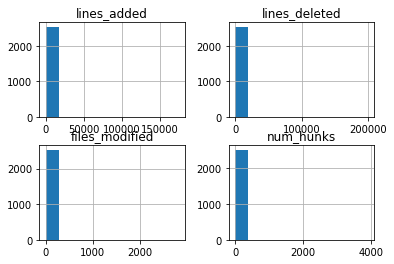

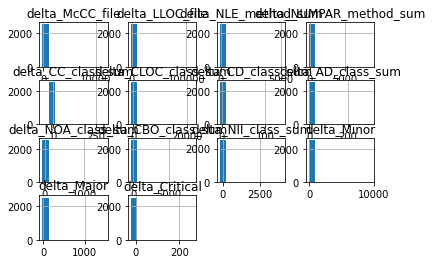

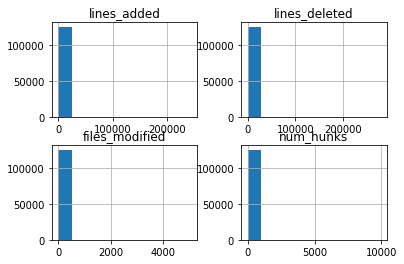

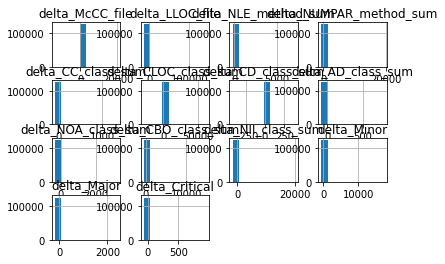

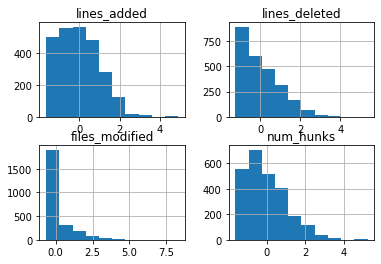

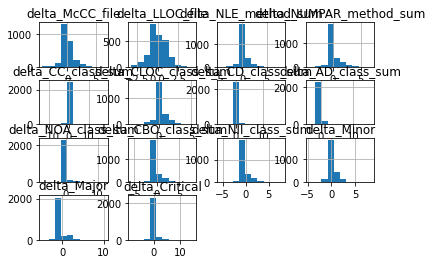

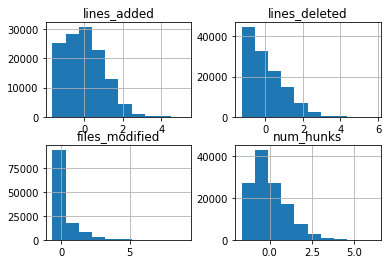

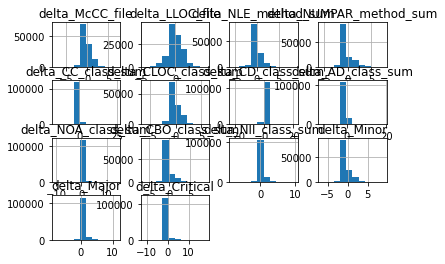

In [16]:
#Data preprocessing/EDA


#Plot histograms of each variables distribution across datasets
print(histogram(df_man_q1h1))
print(histogram(df_man_q1h2))
print(histogram(df_full_q1h1))
print(histogram(df_full_q1h2))

#preprocess dataframes to correct for skew, centering, and scale
df_man_q1h1_norm = preprocessData(df_man_q1h1, q1h1)
df_man_q1h2_norm = preprocessData(df_man_q1h2, q1h2)
df_full_q1h1_norm = preprocessData(df_full_q1h1, q1h1)
df_full_q1h2_norm = preprocessData(df_full_q1h2, q1h2)


#Plot histograms of each variables distribution across datasets again to show normalization
print(histogram(df_man_q1h1_norm))
print(histogram(df_man_q1h2_norm))
print(histogram(df_full_q1h1_norm))
print(histogram(df_full_q1h2_norm))

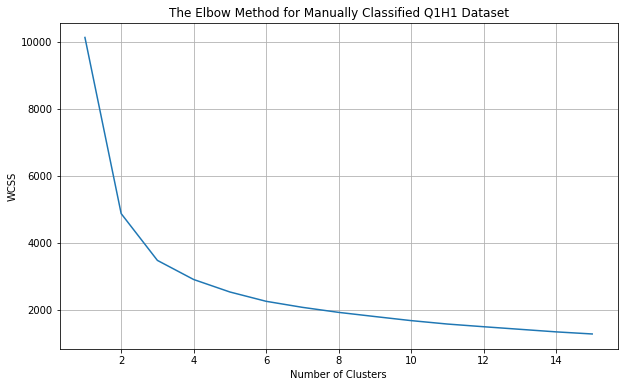

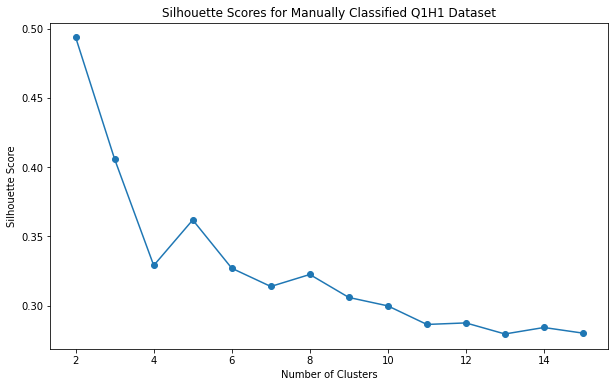

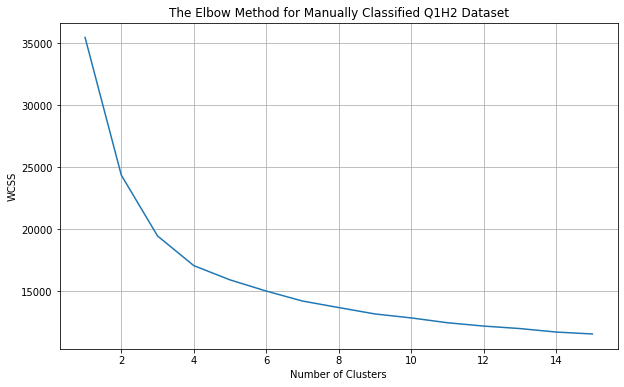

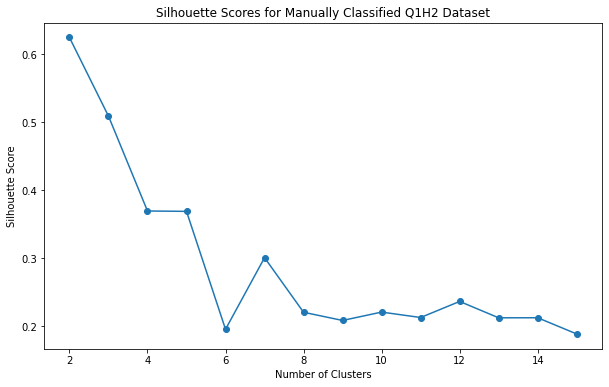

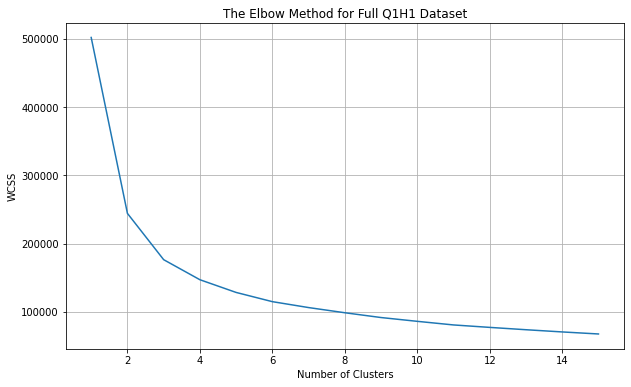

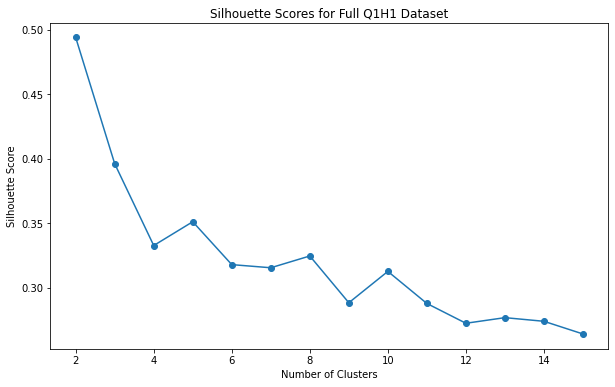

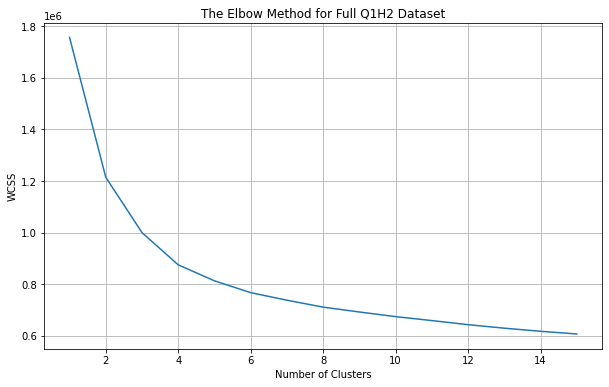

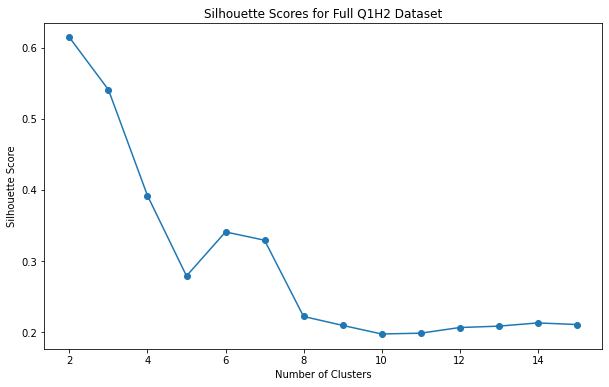

In [17]:
#Producing Elbow Graphs for Each dataset


#Creating input data for clustering and elbow graph
X_man_q1h1 = df_man_q1h1_norm.loc[:, q1h1].values
X_man_q1h2 = df_man_q1h2_norm.loc[:, q1h2].values
X_full_q1h1 = df_full_q1h1_norm.loc[:, q1h1].values
X_full_q1h2 = df_full_q1h2_norm.loc[:, q1h2].values

#Elbow Graphs
elbowGraph(X_man_q1h1, 15, 'Manually Classified Q1H1 Dataset')
elbowGraph(X_man_q1h2, 15, 'Manually Classified Q1H2 Dataset')
elbowGraph(X_full_q1h1, 15, 'Full Q1H1 Dataset')
elbowGraph(X_full_q1h2, 15, 'Full Q1H2 Dataset')


In [18]:
#Establishing clusters from K-Means Clustering and producing cluster labels


#Establish clusters
n=3 #number of clusters

kmeans_man_q1h1 = kmeansClustering(n, X_man_q1h1)
kmeans_man_q1h2 = kmeansClustering(n, X_man_q1h2)
kmeans_full_q1h1 = kmeansClustering(n, X_full_q1h1)
kmeans_full_q1h2 = kmeansClustering(n, X_full_q1h2)

#Create true labels (from paper's classification results)
y_man = trueLabels(df_manual)
y_full = trueLabels(df_full)



#Create cluster labels
y_pred_man_q1h1 = predLabels(X_man_q1h1, kmeans_man_q1h1)
y_pred_man_q1h2 = predLabels(X_man_q1h2, kmeans_man_q1h2)
y_pred_full_q1h1 = predLabels(X_full_q1h1, kmeans_full_q1h1)
y_pred_full_q1h2 = predLabels(X_full_q1h2, kmeans_full_q1h2)




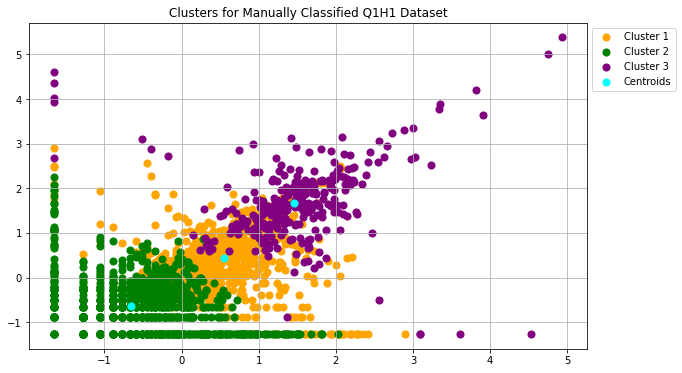

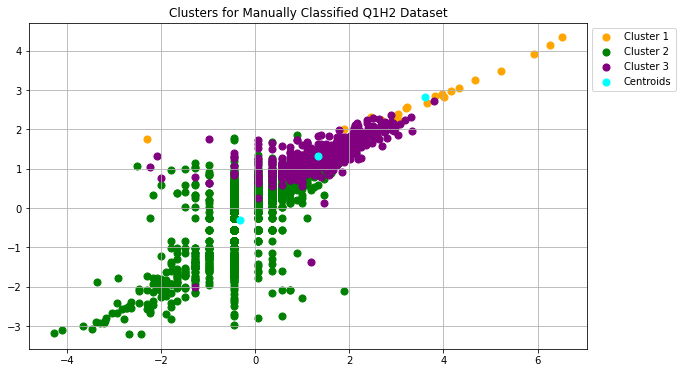

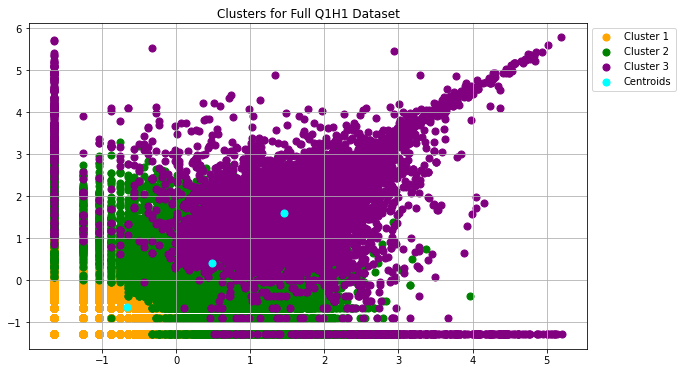

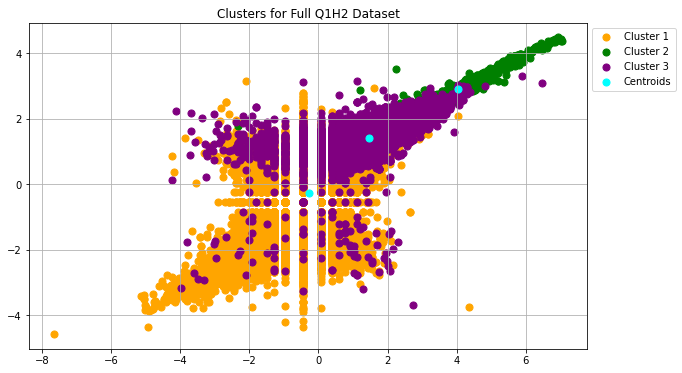

In [19]:
#Visualizing clusters for each dataset
visualizeClusters(X_man_q1h1, y_pred_man_q1h1, kmeans_man_q1h1, 'Manually Classified Q1H1 Dataset')
visualizeClusters(X_man_q1h2, y_pred_man_q1h2, kmeans_man_q1h2, 'Manually Classified Q1H2 Dataset')
visualizeClusters(X_full_q1h1, y_pred_full_q1h1, kmeans_full_q1h1, 'Full Q1H1 Dataset')
visualizeClusters(X_full_q1h2, y_pred_full_q1h2, kmeans_full_q1h2, 'Full Q1H2 Dataset')

In [20]:
#Print metrics for each datasets' cluster model
clusterMetrics(X_man_q1h1, y_man, y_pred_man_q1h1, 'Manually Classified Q1H1 Dataset')
clusterMetrics(X_man_q1h2, y_man, y_pred_man_q1h2, 'Manually Classified Q1H2 Dataset')
clusterMetrics(X_full_q1h1, y_full, y_pred_full_q1h1, 'Full Q1H1 Dataset')
clusterMetrics(X_full_q1h2, y_full, y_pred_full_q1h2, 'Full Q1H2 Dataset')

Summary scores of KMeans clustering for data in Manually Classified Q1H1 Dataset:
Adjusted Random Score: 0.012307371241714318
Mutual Info Score: 0.026356095879918197
Silhouette Score: 0.4056303344085801
Summary scores of KMeans clustering for data in Manually Classified Q1H2 Dataset:
Adjusted Random Score: 0.041953859361395125
Mutual Info Score: 0.051829355659546036
Silhouette Score: 0.5087599259988582
Summary scores of KMeans clustering for data in Full Q1H1 Dataset:
Adjusted Random Score: 0.21109649821536094
Mutual Info Score: 0.02335737846562478
Silhouette Score: 0.3961088793952457
Summary scores of KMeans clustering for data in Full Q1H2 Dataset:
Adjusted Random Score: -0.9789060813385586
Mutual Info Score: 0.04934602275595279
Silhouette Score: 0.5406232829182636
